# Plots for Single Samples and Time Series
## Histogram
- In both the single sample and time-series case, considering frequencies of occurrences is generally an insightful way to visualize the data. The most standard mechanism for plotting frequencies is the ***histogram***. Mathematically, a histogram can be defined as follows. 
  1. First denote the support of the observations via $[\ell, m]$, where $\ell$ is the minimal observation and $m$ is the maximal observation.
  2. Then the interval $[\ell, m]$ canbe partitioned into a finite set of ***bins*** $\mathcal{B}_{1}, \cdots, \mathcal{B}_{L}$, and the frequency in each bin is recorded via
  $$
  f_{j} = \frac{1}{n}\sum_{i=1}^{n}\pmb{1}\{x_{i} \in \mathcal{B}_{j}\},\quad \text{for }j = 1,\cdots, L 
  $$
    - Here $\pmb{1}\{\cdot\}$ is $1$ if $x_{i}\in\mathcal{B}_{j}$ or $0$ if $x_{i}\notin \mathcal{B}_{j}$
  3. A histogram is then just a visual representation of the discrete probability distribution (the frequencies). One way to plot the frequencies is via a ***stem plot***. However, such a plot cannot represent the widths of the bins. Hence, an alernative representation is via a ***histrogram function*** $h(x)$ which is a scaled plot of the frequencies $f_{1},\cdots, f_{L}$. The function $h(x)$ is defined for any $x\in[\ell, m]$. It is constructed by staying constant on all values $x\in\mathcal{B}_{j}$, at a hight of $f_{j}/\vert \mathcal{j} \vert$, where $\vert \mathcal{B}_{j} \vert$ is the width of bin $j$. This ensures the total area under the plot is $1$. Hence $h(x)$ is actually a probability density function, and can be compared to probability densities.
  $$
  h(x) = \sum_{j=1}^{L}\frac{f_{j}}{\vert \mathcal{B_{j}} \vert}\pmb{1}\{x\in \mathcal{B}_{j}\} = \frac{f_{b(x)}}{\vert \mathcal{B}_{b(x)} \vert}
  $$
    - where $b(x)$ is the bin of $x$, that is $x\in\mathcal{B}_{b(x)}$
- Plots in Julia

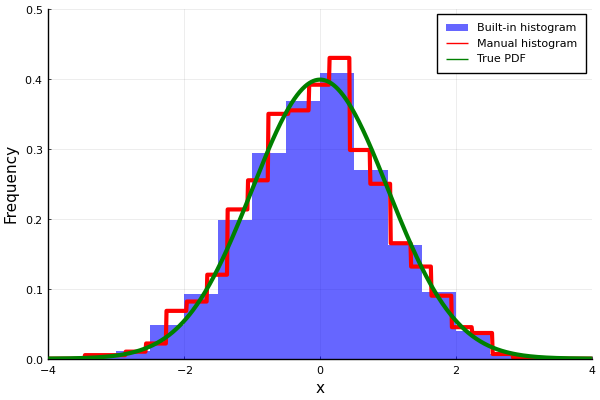

In [8]:
using Plots, Distributions, Random; pyplot()
Random.seed!(0)

n = 2000
data = rand(Normal(), n)
l, m = minimum(data), maximum(data)

delta = 0.3;
bins = [(x, x + delta) for x in l:delta:m-delta]
if last(bins)[2] < m
    push!(bins, (last(bins)[2], m))
end
L = length(bins)

inBin(x,j) = first(bins[j]) <= x && x < last(bins[j])
sizeBin(j) = last(bins[j]) - first(bins[j])
f(j) = sum([inBin(x,j) for x in data])/n
h(x) = sum([f(j)/sizeBin(j) * inBin(x,j) for j in 1:L])

xGrid = -4:0.01:4
histogram(data,normed=true, bins=L,
    label="Built-in histogram",
    c=:blue, la=0, alpha=0.6)
plot!(xGrid, h.(xGrid), lw=3, c=:red, label="Manual histogram", 
    xlabel="x", ylabel="Frequency")
plot!(xGrid, pdf.(Normal(), xGrid), label="True PDF",
    lw=3, c=:green, xlims=(-4,4),ylims=(0,0.5))

In [18]:
h(0) == f(12)/(last(bins[12])-first(bins[12]))

true

## Density Plots and Kernel Density Estimation
- A modern and visually appealing alternative to histogram is the ***smoothed histogram***, also known as a ***density plot***, often generated via a ***kernel density estimate.***
- This example and the next are based on synthetic data from a ***mixture model***. Such models are useful for situations where we sample from populations made up of heterogeneous sub-populations. Each sub-population has its own probability distribution and these are "mixed" in the process of sampling. At first a ***latent*** random variable determines which sub-population is used, and then a sample is taken from that sub-population. In terms of random variable generation, creating a mixture simply involves first randomly selecting which probability distribution is used, and then generating an observation from it. Also, the probability density function of the mixture is a ***convex combination*** of the probability density functions of each of the sub-populations. That is, if the $M$ sub-populations have densities $g_{1}(x),\cdots, g_{M}(x)$ with weights, $p_{1},\cdots, p_{M}$ and $\sum(p_{i}) = 1$, then the density of the mixture is
$$
f(x) = \sum_{i=1}^{M}p_{1}g_{i}(x)
$$

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1342


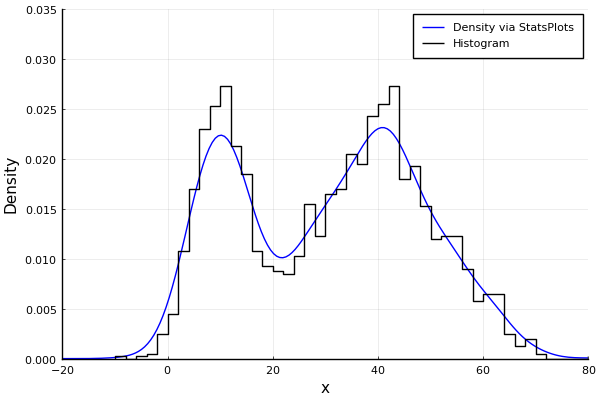

In [19]:
using Random, Distributions, StatsPlots; pyplot()
Random.seed!(0)

mu1, sigma1 = 10, 5
mu2, sigma2 = 40, 12
dist1, dist2 = Normal(mu1, sigma1), Normal(mu2, sigma2)
p = 0.3
mixRv() = (rand() <= p) ? rand(dist1) : rand(dist2)

n = 2000
data = [mixRv() for _ in 1:n]

density(data, c=:blue, label="Density via StatsPlots",
    xlims=(-20, 80), ylims=(0,0.035))
stephist!(data, bins=50, c=:black, norm=true,
    label="Histogram", xlabel="x", ylabel="Density")

- A typical way creating a density plot is via ***kernel density estimation (KDE)***, which is a way of fitting a probability function to data. In certain cases, we may wish to have access to the estimated density. For this we use the `kde()` function from the `KernelDensity` package.
- Given a set of observations, $x_{1},\cdots, x_{n}$, the KDE is the function,
$$
\hat{f}(x) = \frac{1}{n}\sum_{i=1}^{n}\frac{1}{h}K\bigg(\frac{x-x_{i}}{h}\bigg)
$$
  - where $K(\cdot)$ is some specified ***kernel function*** and $h>0$ is the ***bandwidth*** parameter. The kernel function is a function that statisfies the properties of PDF. A typical example is the Gaussian kernel.
  $$
  K(x) = \frac{1}{\sqrt{2\pi}}e^{-x^{2}/2}
  $$
  - With such a kernel the estimator $\hat{f}(x)$ is a PDF because it is a weighted superposition of scaled kernel functions centered about each of the observations. Like histograms, KDEs are not unique as they depend on the type of the observations and more importantly on the bandwith parameter. A very small bandwith implies that the density,
  $$
  \frac{1}{h}K\bigg(\frac{x-x_{1}}{h}\bigg),
  $$
  - is very concentrated around $x_{i}$. This in turn implies that KDE is comprised of a superposition of very concentrated functions, one for each observation. In contrast, a very large bandwith implies that the density around each observation has a very wide spread. This will make the KDE "smear" over a wide range. Hence ideally, the bandwidth is not too small nor too large.
  - For any value of $h$, it can be proved under general conditions that if data is distributed according to some density $f(\cdot)$, then $\hat{f}(\cdot)$ converge to $f(\cdot)$ when the sample size grows. Nevertheless, in practice, choosing the bandwidth is a key issue in the application of KDE. A default classic rule is ***Silverman's rule***, which is based on the sample standard deviation of the sample, which is:
  $$
  h = \bigg(\frac{4}{3}\bigg)^{1/6}sn^{-1/5} \approx 1.06sn^{-1/5}
  $$

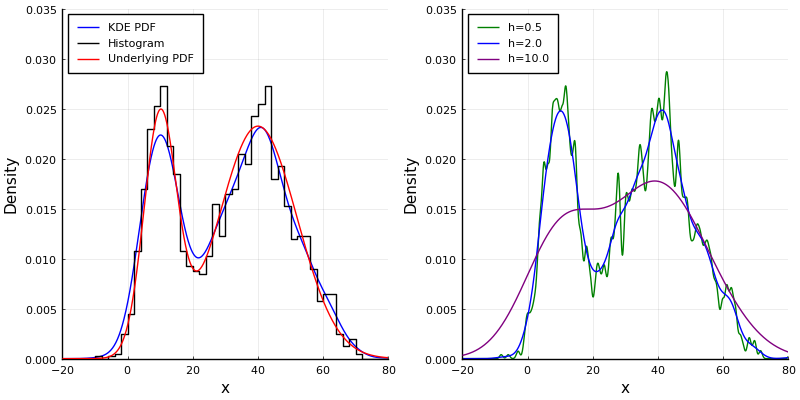

In [25]:
using Random, Distributions, KernelDensity, Plots;pyplot()
Random.seed!(0)

mu1, sigma1 = 10, 5
mu2, sigma2 = 40, 12
dist1, dist2 = Normal(mu1, sigma1), Normal(mu2, sigma2)
p = 0.3
mixRv() = rand() <= p ? rand(dist1) : rand(dist2)
mixPDF(x) = p * pdf(dist1,x) + (1-p) * pdf(dist2,x)

n = 2000
data = [mixRv() for _ in 1:n]

kdeDist = kde(data)

xGrid = -20:0.1:80
pdfKDE = pdf(kdeDist, xGrid)

plot(xGrid, pdfKDE, c=:blue, label="KDE PDF")
stephist!(data, bins=50, c=:black, normed=true, label="Histogram")
p1 = plot!(xGrid, mixPDF.(xGrid), c=:red, label="Underlying PDF",
    xlims=(-20,80), ylims=(0,0.035), legend=:topleft,
    xlabel="x", ylabel="Density")

hVals = [0.5, 2, 10]
kdeS = [kde(data, bandwidth=h) for h in hVals]
plot(xGrid, pdf(kdeS[1], xGrid), c = :green, label="h=$(hVals[1])")
plot!(xGrid, pdf(kdeS[2], xGrid), c = :blue, label="h=$(hVals[2])")
p2 = plot!(xGrid, pdf(kdeS[3], xGrid), c = :purple, label="h=$(hVals[3])",
    xlims=(-20, 80), ylims=(0, 0.035), legend=:topleft,
    xlabel="x", ylabel="Density")
plot(p1,p2, size = (800,400))


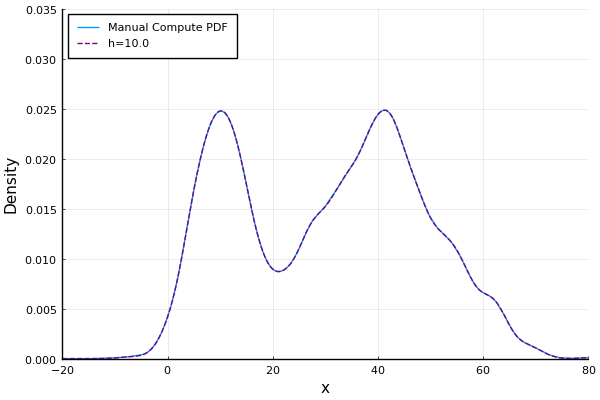

In [38]:
f̂(h,x) = 1/length(data) * sum([1/(sqrt(2pi)*h)*exp(-((x-xi)/h)^2/2) for xi in data])
f1(x) = f̂(2,x)
plot(x->f1(x),xlims=(-20, 80), ylims=(0, 0.035), label="Manual Compute PDF")
plot!(xGrid, pdf(kdeS[2], xGrid), c = :purple, label="h=$(hVals[3])",
    xlims=(-20, 80), line=:dash ,ylims=(0, 0.035), legend=:topleft,
    xlabel="x", ylabel="Density")

## Empirical Cumulative Distribution Funcitons
- The ***Empirical Cumulative Distribution Function (ECDF)*** can be viewed as an estimate of the underlying CDF. In contrast to histograms and KDEs, ECDFs provide a unique representation of the data not dependent on tuning parameters.
- The ECDF is a stepped funciton which, given $n$ data plots, increases by $1/n$ at each point. Mathematically, given the sample, $x_{1},\cdots,x_{n}$ the ECDF is given by
$$
\hat{F}(t) = \frac{1}{n}\sum_{i=1}^{n}\pmb{1}\{x_{i} \le t\} \quad \text{where } \pmb{1}\{\cdot\} \text{ is the indicator function.}
$$
  - In the case of i.i.d. data from an underlying distribution with CDF $F(\cdot)$, the ***Glivenko-Cantelli theorem*** ensures that the ECDF $\hat{F}(\cdot)$ approaches $F(\cdot)$ as the sample size grows.
- Constructing an ECDF in Julia
  - `ecdf()`

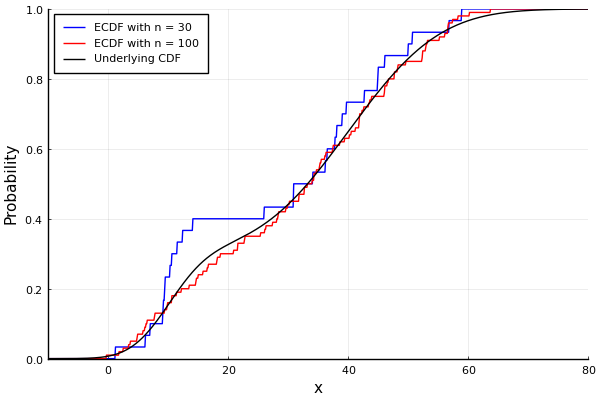

In [39]:
using Random, Distributions, StatsBase, Plots; pyplot()
Random.seed!(0)

mu1, sigma1 = 10, 5
mu2, sigma2 = 40, 12
dist1, dist2 = Normal(mu1, sigma1), Normal(mu2, sigma2)
p = 0.3
mixRv() = (rand() <= p) ? rand(dist1) : rand(dist2)
mixCDF(x) = p * cdf(dist1, x) + (1-p) * cdf(dist2,x)

n = [30, 100]
data1 = [mixRv() for _ in 1:n[1]]
data2 = [mixRv() for _ in 1:n[2]]

empiricalCDF1 = ecdf(data1)
empiricalCDF2 = ecdf(data2)

xGrid = -10:0.1:80
plot(xGrid, empiricalCDF1.(xGrid), c=:blue, label="ECDF with n = $(n[1])")
plot!(xGrid, empiricalCDF2.(xGrid), c=:red, label="ECDF with n = $(n[2])")
plot!(xGrid, mixCDF.(xGrid), c=:black, label="Underlying CDF",
    xlims=(-10,80), ylims=(0,1),
    xlabel="x", ylabel="Probability", legend=:topleft)

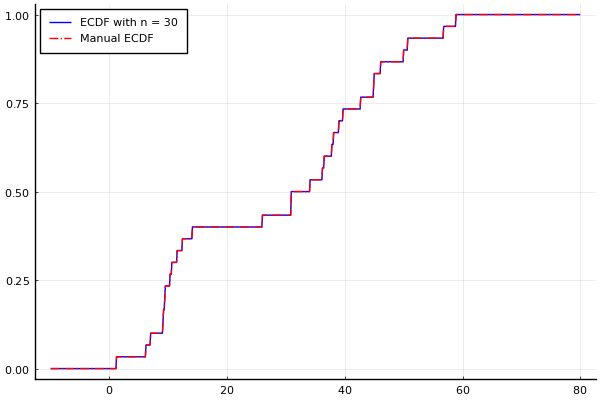

In [53]:
manualECDF(data::AbstractArray,x) = 1/length(data)*sum([xi <= x for xi in data])
MempiricalCDF1(x) = manualECDF(data1,x)
plot(xGrid, empiricalCDF1.(xGrid), c=:blue, label="ECDF with n = $(n[1])")
plot!(xGrid, MempiricalCDF1.(xGrid), c=:red, line=:dashdot, label="Manual ECDF", legend=:topleft)

## Normal Probability Plot
- ***Normal probability plot*** can be used to indicate if it is likely that a dataset has come from a population that is normally distributed or not. It works by plotting the quantiles of the dataset in question against the theoretical quantiles that one would expect if the sample data came from a normal distribution, and checking if plot is linear. The normal probability plot is actually a special case of the more generalized ***Q-Q plot***, or ***quantile-quantile plot***.
- In order to create a normal probability plot, the data points are first sorted in ascending order, $x_{1},\cdots, x_{n}$, then the quantiles of each data points are calculated. Finally, $n$ equally spaced quantiles of the standard normal distribution are calculated, and each ascending quantile pair is then plotted. If the data comes from a normal distribution then we expect the normal probability plot to follow a straight line, otherwise not. An alternative view of the normal probability plot is to think of the ECDF of the data, plotted with the $y$-axis stretched according to the inverse of the CDF of the normal distribution.
- Normal Probability Plot in Julia

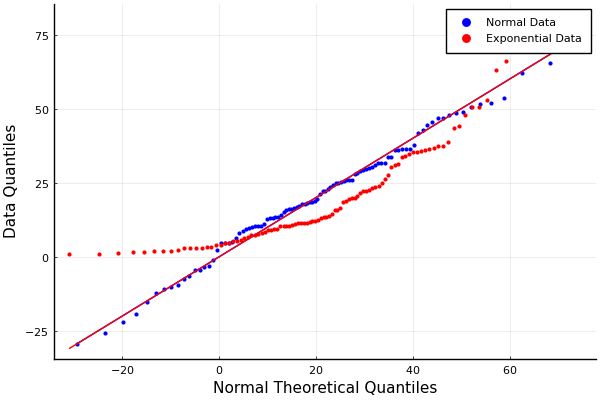

In [56]:
using Random, Distributions, StatsPlots, Plots; pyplot()
Random.seed!(0)

mu = 20
d1, d2 = Normal(mu,mu), Exponential(mu)

n = 100
data1 = rand(d1, n)
data2 = rand(d2, n)

qqnorm(data1, c=:blue, ms=3, msw=0, label="Normal Data")
qqnorm!(data2, c=:red, ms=3, msw=0, label="Exponential Data",
    xlabel="Normal Theoretical Quantiles",
    ylabel="Data Quantiles", legend=:true)

## Visualizing Time series
- In general, when confronted with time-series data, simply plotting a histogram of the data can be misleading because the frequencies in the histogram can be greatly affected by trends or cyclic patterns in the data.
- Nevertheless, <font style="color:#D0104C">in cases where the time-series data appears to be ***stationary***, then a histogram is immediately insightful.</font> Broadly speaking, a stationary sequence is one in which the distributional law of observations does not depend on the exact time.
- Example in Julia
  - The top left plot presents two time series of temperature data in the adjacent locations of Brisbane and Gold Coast Australia. As apparent from the plot, the sequences are clearly non- stationary. This is because of seasonality. The top right plot shows a zoomed-in view of a specific fortnight. The bottom left plot is a time series of the differences in temperatures between Brisbane and Gold Coast. On initial inspection, this time series appears to be stationary. Hence, for the difference, we plot a histogram in the bottom right.

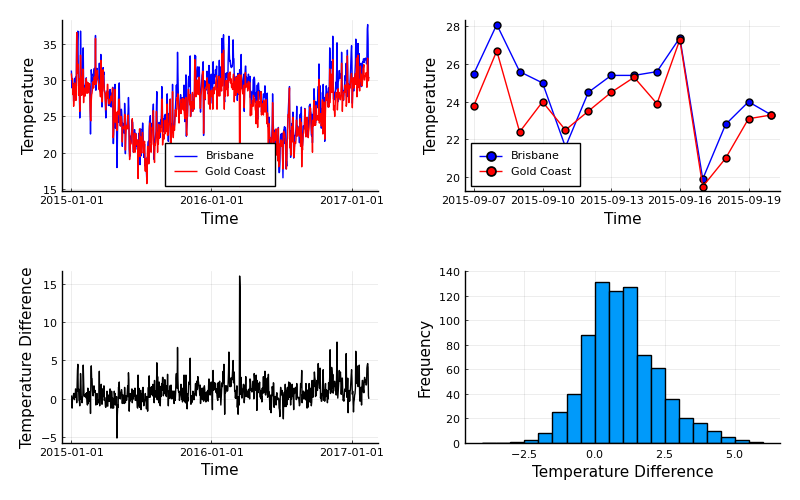

In [76]:
using DataFrames, CSV, Statistics, Dates, Plots, Measures; pyplot()

data = CSV.read("../data/temperatures.csv", DataFrame)
brisbane = data.Brisbane
goldcoast = data.GoldCoast

diff = brisbane - goldcoast
dates = [Date(
    Year(data.Year[i]),
    Month(data.Month[i]),
    Day(data.Day[i])
) for i in 1:nrow(data)]
fortnightRange = 250:263
brisFortnight = brisbane[fortnightRange]
goldFortnight = goldcoast[fortnightRange]

default(xlabel="Time", ylabel="Temperature")
# default(label=["Brisbane" "Gold Coast"])

p1 = plot(dates, [brisbane goldcoast], label=["Brisbane" "Gold Coast"],
    c=[:blue :red], legend=:bottom)
p2 = plot(dates[fortnightRange], [brisFortnight goldFortnight], label=["Brisbane" "Gold Coast"],
    c=[:blue :red], m=(:dot, 5, Plots.stroke(1)), legend=:bottomleft)
p3 = plot(dates, diff,
    c=:black, ylabel="Temperature Difference", legend=false)
p4 = histogram(diff, bins=-4:0.5:6, 
    ylims=(0,140), legend=false,
    xlabel="Temperature Difference", ylabel="Frequency")
plot(p1,p2,p3,p4, size=(800,500), margin=5mm)

In [80]:
default(xlabel="", ylabel="")

## Radial Plot
- It is often useful to plot time-series data, or cylic data, on a so-called ***radial plot***. Such a plot involves plotting data on a polar coordinate system. This plot can be used to help visualize the nature of dataset comparing the distances of each data point radially from the origin. A variation of the radial plot is the ***radar plot***, which is often used to visualize the levels of different categorical variables on the one plot.
- We present the effect of different forms of ***smoothing*** on the time-series data. For this, we carry out a ***moving average*** on the data. Roughly, this transforms the original data sequence $x_{1},\cdots, x_{n}$ into a smoother sequence $\tilde{x}_{1}, \cdots, \tilde{x}_{n}$ via
$$
\tilde{x}_{i} = \frac{1}{L}\sum_{j=0}^{L-1}x_{i-j}
$$
  - Here, each $\tilde{x}_{i}$ is the average of the $L$ observations $x_{x_{i-L+1}},\cdots, x_{i}$ neihboring time $i$ in the oringinal sequence. A critical parameter is the ***window size*** $L$ which determines "how much smoothing" is to be performed, as $L$ is increased more smoothing takes place.
- Plots in Julia
  - `moving(f::Function, d::AbstractArray, w::Int)`: moving function on data in width `w`

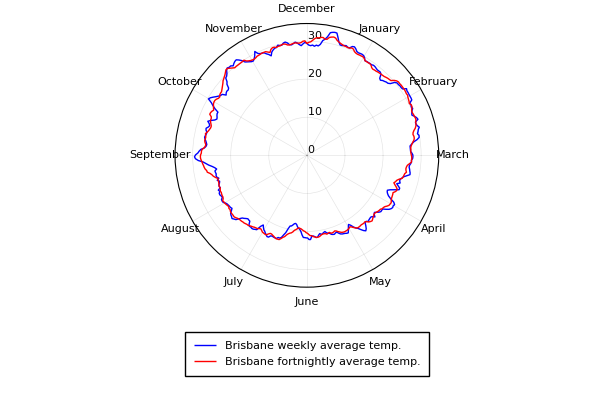

In [81]:
using DataFrames, CSV, Dates, StatsBase, Plots, TimeSeries; pyplot()

data = CSV.read("../data/temperatures.csv", DataFrame, copycols = true)
brisbane = data.Brisbane
dates = [Date(
    Year(data.Year[i]),
    Month(data.Month[i]),
    Day(data.Day[i])
) for i in 1:nrow(data)]

window1, window2 = 7, 14
d1 = values(moving(mean, TimeArray(dates, brisbane), window1))
d2 = values(moving(mean, TimeArray(dates, brisbane), window2))

grid = (2pi:-2pi/365:0) .+ pi/2
monthNames = Dates.monthname.(dates[1:31:365])

plot(grid, d1[1:365], 
    c=:blue, proj=:polar, label="Brisbane weekly average temp.")
plot!(grid, d2[1:365],
    xticks=([mod.((11pi/6:-pi/6:0) .+ pi/2, 2pi);], monthNames),
    c=:red, proj=:polar,
    label="Brisbane fortnightly average temp.", legend=:outerbottom)